# DeepFace face detection tests

Some small tests with dectecting faces on some small images, before running face
detection & matching on our archive of several terabytes of photos.

* No special color profiles of Canon cameras: converted to normal JPEGs
* Scaled down, square images of only 1024x1024 pixels
* Faces not obstructed, no sunglasses
* Python typing everywhere, to make it clear what kind of objects are used
* Everything off-line, no OpenAI

In [62]:
from deepface import DeepFace
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import patches
import numpy as np
import typing

3 test images:
* Carolien on her own, having a drink
* Carolien on her own, again having a drink, but my face is reflected on some glass wall
* Carolien with her godchild on her lap, with their faces very close to each other

<Figure size 900x300 with 0 Axes>

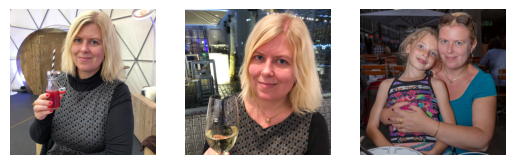

In [63]:
img1_name: str = 'test_files/test-image-carolien-montreux-2018.jpg'
img2_name: str = 'test_files/test-image-carolien-geneva-2018.jpg'
img3_name: str = 'test_files/test-image-carolien-bern-2018-with-child.jpg'

def show_single_image(filename: str) -> None:
  """ Show an image with matplotlib in a notebook """
  img: np.ndarray = plt.imread(filename)
  plt.figure(figsize=(3.,3.))
  plt.imshow(img)

def show_images_in_row(filenames: typing.List[str]) -> None:
  """ show multiple images in a row """
  plt.figure(figsize=(len(filenames)*3., 3.))
  _, _axes = plt.subplots(1, len(filenames))
  axes: typing.List[Axes] = typing.cast(typing.List[Axes], _axes)
  for i, filename in enumerate(filenames):
    axes[i].set_axis_off()
    img: np.ndarray = plt.imread(filename)
    axes[i].imshow(img)

show_images_in_row([img1_name, img2_name, img3_name])

The extract_faces() method of DeepFace returns a quite weird data structure. For convencience,
some class which makes the return value slightly easier to use:

In [64]:
class ExtractedFaceWrapper:
  """ wrap the result of 1 extraced face by DeepFace, to avoid having to deal
  with a weird dict with different types of values """
  def __init__(self, detected_face_info: typing.Dict[str,typing.Any]) -> None:
    self.face: np.ndarray = detected_face_info['face']
    self.face_area: typing.Dict[str,int] = detected_face_info['facial_area']
    self.confidence: float = detected_face_info['confidence']

def wrap_extracted_faces(extracted_faces: typing.List[typing.Dict[str,typing.Any]]) -> typing.List[ExtractedFaceWrapper]:
  """ convert the list of dicts of extracted faces into more convenient objects """
  return [ExtractedFaceWrapper(x) for x in extracted_faces]

Let's test on one of the images:

In [65]:
extracted_faces: typing.List[ExtractedFaceWrapper] = wrap_extracted_faces(DeepFace.extract_faces(img_path=img2_name))
print(f"Number of detected faces: {len(extracted_faces)}")
for i, face in enumerate(extracted_faces):
  print(f"Face detected at {face.face_area} with confidence {face.confidence}")

Number of detected faces: 2
Face detected at {'x': 361, 'y': 179, 'w': 473, 'h': 473} with confidence 8.475467131356709
Face detected at {'x': 210, 'y': 496, 'w': 109, 'h': 109} with confidence 6.327956058434211


Let's show the original image and all the faces that are detected within that image, by drawing the bounding boxes around the faces:

<Figure size 400x400 with 0 Axes>

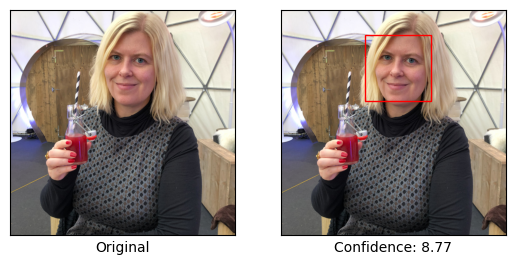

<Figure size 800x400 with 0 Axes>

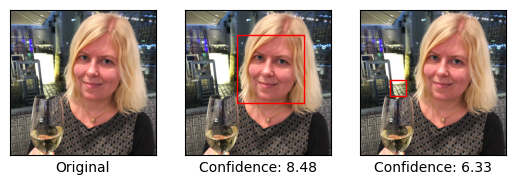

<Figure size 400x400 with 0 Axes>

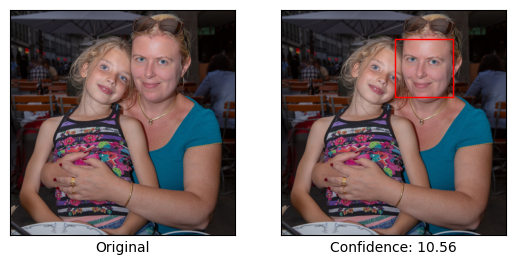

In [66]:
def show_detected_faces(filename: str, detector_backend: str = "opencv") -> None:
  """ show an image for each detected face
  Default detector backend of DeepFace is opencv """
  extracted_faces: typing.List[ExtractedFaceWrapper] = wrap_extracted_faces(DeepFace.extract_faces(img_path=filename, detector_backend=detector_backend))
  if len(extracted_faces) == 0:
    print("No faces detected")
  else:
    plt.figure(figsize=(len(extracted_faces)*4., 4.))
    _, _axes = plt.subplots(1, len(extracted_faces) + 1)
    axes: typing.List[Axes] = typing.cast(typing.List[Axes], _axes)
    img: np.ndarray = plt.imread(filename)
    axes[0].imshow(img)
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[0].set_xlabel("Original")
    for i, face in enumerate(extracted_faces):
      axes[i+1].set_xticks([])
      axes[i+1].set_yticks([])
      img = plt.imread(filename)
      axes[i+1].imshow(img)
      rect = patches.Rectangle((face.face_area['x'], face.face_area['y']), face.face_area['w'], face.face_area['h'], linewidth=1, edgecolor='r', facecolor='none')
      axes[i+1].add_patch(rect)
      axes[i+1].set_xlabel(f"Confidence: {face.confidence:.2f}")

show_detected_faces(img1_name)
show_detected_faces(img2_name)
show_detected_faces(img3_name)

As you can see, the results are quite bad:
* The second image has a false positive.
* On the third image, the child is not detected.

According to the documentation, you can easily use a different backend. The 'retinaface' backend seems to give the best results, but it takes quite a bit longer to detect the faces:

<Figure size 400x400 with 0 Axes>

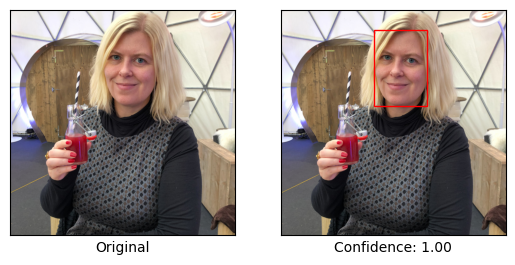

<Figure size 800x400 with 0 Axes>

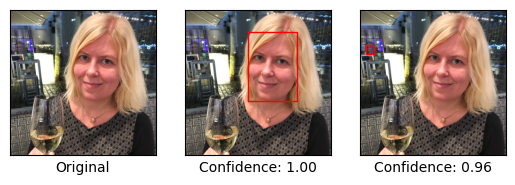

<Figure size 800x400 with 0 Axes>

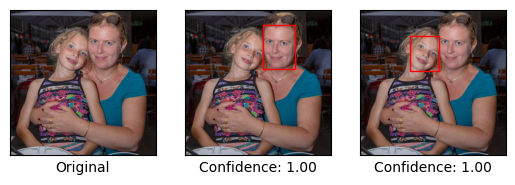

In [67]:
show_detected_faces(img1_name, detector_backend="retinaface")
show_detected_faces(img2_name, detector_backend="retinaface")
show_detected_faces(img3_name, detector_backend="retinaface")